# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries

First, let's import the necessary libraries.

In [7]:
import sys

sys.path.append("")

import numpy as np
import pandas as pd
import pyreadr
from typing import Dict, Any
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.ridge_model_builder import RidgeModelBuilder
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeaturizedMMMData, FeatureEngineering

## 2.1 Load Mock R data

In [8]:
def load_data() -> Dict[str, pd.DataFrame]:
    result = pyreadr.read_r("")
    dt_simulated_weekly = result["dt_simulated_weekly"]
    result_holidays = pyreadr.read_r("")
    dt_prophet_holidays = result_holidays["dt_prophet_holidays"]
    return {"dt_simulated_weekly": dt_simulated_weekly, "dt_prophet_holidays": dt_prophet_holidays}


data = load_data()
data["dt_simulated_weekly"].head()
data["dt_prophet_holidays"].head()

,ds,holiday,country,year
0,1995-01-01,New Year's Day,AD,1995
1,1995-01-06,Epiphany,AD,1995
2,1995-02-28,Carnival,AD,1995
3,1995-03-14,Constitution Day,AD,1995
4,1995-04-14,Good Friday,AD,1995


## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [9]:
def setup_mmm_data(data: Dict[str, pd.DataFrame]) -> MMMData:
    dt_simulated_weekly = data["dt_simulated_weekly"]

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        prophet_vars=["trend", "season", "holiday"],
        prophet_country="DE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(data)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Engineering

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

Hyperparameters setup complete.
Processing tv_S
spend_data range: 0.0 - 158046.57333333333
exposure_data range: 0.0 - 158046.57333333333
Error fitting models for tv_S: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Processing ooh_S
spend_data range: 0.0 - 500361.60000000003
exposure_data range: 0.0 - 500361.60000000003
Error fitting models for ooh_S: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Processing print_S
spend_data range: 0.0 - 27998.13333333333
exposure_data range: 0.0 - 27998.13333333333
Error fitting models for print_S: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Processing facebook_S
spend_data range: 0.0 - 13900.619233961634
exposure_data range: 0.0 - 48661981.684228


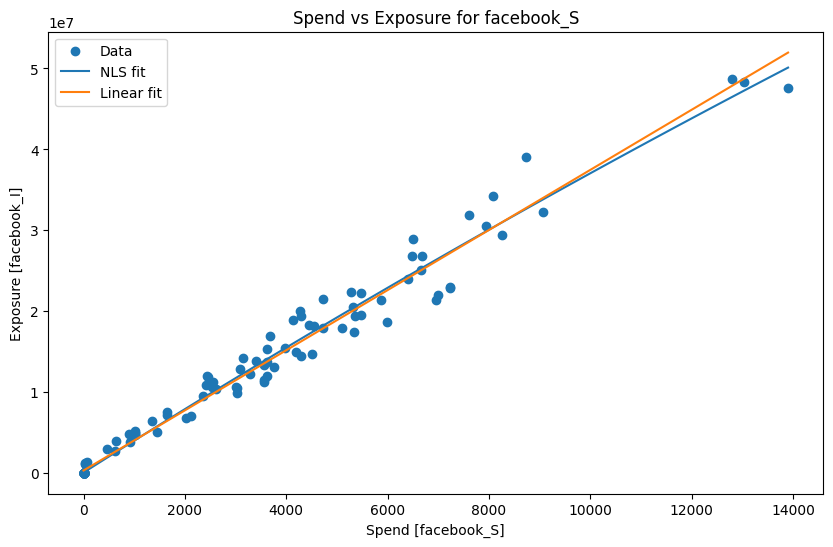

Processing search_S
spend_data range: 0.0 - 17146.666666666668
exposure_data range: 0.0 - 52188.128214422664


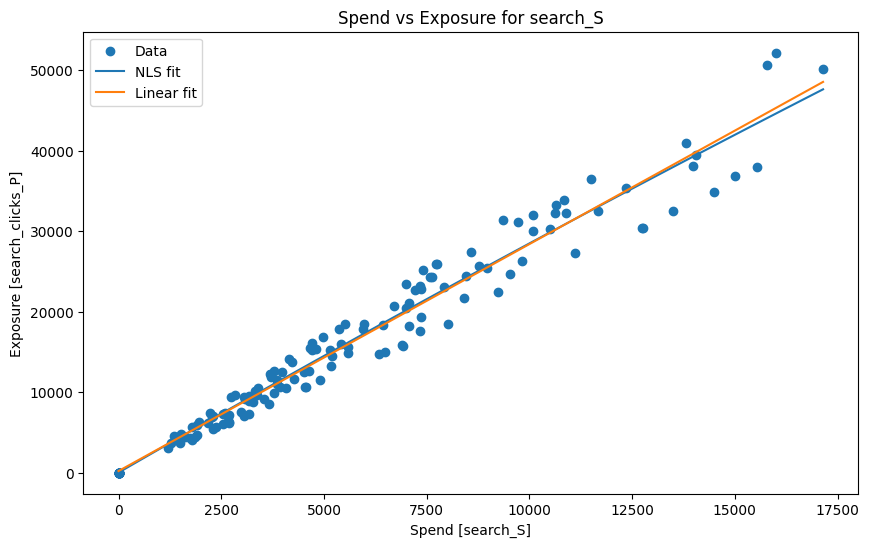

Feature engineering complete.


In [11]:
def setup_hyperparameters() -> Hyperparameters:
    return Hyperparameters(
        hyperparameters={
            "facebook_S_alphas": [0.5, 3],
            "facebook_S_gammas": [0.3, 1],
            "facebook_S_thetas": [0, 0.3],
            "print_S_alphas": [0.5, 3],
            "print_S_gammas": [0.3, 1],
            "print_S_thetas": [0.1, 0.4],
            "tv_S_alphas": [0.5, 3],
            "tv_S_gammas": [0.3, 1],
            "tv_S_thetas": [0.3, 0.8],
            "search_S_alphas": [0.5, 3],
            "search_S_gammas": [0.3, 1],
            "search_S_thetas": [0, 0.3],
            "ooh_S_alphas": [0.5, 3],
            "ooh_S_gammas": [0.3, 1],
            "ooh_S_thetas": [0.1, 0.4],
            "newsletter_alphas": [0.5, 3],
            "newsletter_gammas": [0.3, 1],
            "newsletter_thetas": [0.1, 0.4],
        },
        adstock="geometric",
        lambda_=0.0,
        train_size=[0.5, 0.8],
    )


# Setup Hyperparameters
hyperparameters = setup_hyperparameters()
print("Hyperparameters setup complete.")


# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters)
featurized_mmm_data = feature_engineering.perform_feature_engineering()